<a href="https://colab.research.google.com/github/Axlrou/UniversityWork/blob/main/Medical_Imaging_Project_Inbal_Axel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs, imports, downloading and extracting the datasets from Kaggle - Needed just once.

In [ ]:
drive.mount('/content/drive')
chest_xray_zip_path = '/content/drive/MyDrive/datasets/chest-xray-pneumonia.zip'
chest_xray_extract_path = '/content/drive/MyDrive/datasets/chest_xray'
# Extract the Chest X-ray dataset
with zipfile.ZipFile(chest_xray_zip_path, 'r') as zip_ref:
    zip_ref.extractall(chest_xray_extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install torch torchvision opencv-python scikit-learn matplotlib transformers tqdm kaggle

# Create Kaggle directory and copy kaggle.json
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download datasets from Kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/drive/MyDrive/datasets/
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/drive/MyDrive/datasets/
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p /content/drive/MyDrive/datasets/

# Define the path to the zip files in your Google Drive
brain_mri_zip_path = '/content/drive/MyDrive/datasets/brain-mri-images-for-brain-tumor-detection.zip'
chest_xray_zip_path = '/content/drive/MyDrive/datasets/chest-xray-pneumonia.zip'
skin_cancer_zip_path = '/content/drive/MyDrive/datasets/skin-cancer-malignant-vs-benign.zip'

# Define extraction paths
brain_mri_extract_path = '/content/drive/MyDrive/datasets/brain_mri'
chest_xray_extract_path = '/content/drive/MyDrive/datasets/chest_xray'
skin_cancer_extract_path = '/content/drive/MyDrive/datasets/skin-cancer/'


# Extract the Brain MRI dataset
with zipfile.ZipFile(brain_mri_zip_path, 'r') as zip_ref:
    zip_ref.extractall(brain_mri_extract_path)

# Extract the Chest X-ray dataset
with zipfile.ZipFile(chest_xray_zip_path, 'r') as zip_ref:
    zip_ref.extractall(chest_xray_extract_path)

# Extract the Skin Cancer dataset
with zipfile.ZipFile(skin_cancer_zip_path, 'r') as zip_ref:
    zip_ref.extractall(skin_cancer_extract_path)

# Confirm the extracted files
print("Brain MRI contents:", os.listdir(brain_mri_extract_path))
print("Chest X-ray contents:", os.listdir(chest_xray_extract_path))
print("Skin Cancer contents:", os.listdir(skin_cancer_extract_path))


Code starts here: Defining paths for datasets in the Drive

In [ ]:
# File paths for datasets in Google Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths for Brain MRI dataset (change as needed) - yes and no labels
brain_mri_path_yes = '/content/drive/MyDrive/datasets/brain_mri/yes'
brain_mri_path_no = '/content/drive/MyDrive/datasets/brain_mri/no'

# Paths for Chest X-ray dataset (base paths) - in each one there are two labels
chest_xray_train_path = '/content/drive/MyDrive/datasets/chest_xray/chest_xray/chest_xray/train'
chest_xray_test_path = '/content/drive/MyDrive/datasets/chest_xray/chest_xray/chest_xray/test'

# Paths for Skin Cancer dataset (base paths) - in each one there are two labels
skin_cancer_train_path = '/content/drive/MyDrive/datasets/skin-cancer/data/train'
skin_cancer_test_path = '/content/drive/MyDrive/datasets/skin-cancer/data/test'

Work with GPU if available for better efficiency

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Pre processing of the datasets - Load the datasets, rearrange them into train and test sets, normalize the data, create dataloaders

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to load images from folders and convert BGR to RGB
def load_images_from_folder(folder, label):
    X, y = [], []
    for filename in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image = cv2.resize(image, (224, 224))  # Resize to 224x224
            X.append(image)
            y.append(label)
    return X, y

# Function to load Brain MRI dataset and split it
def load_dataset_brain_mri(folder_yes, folder_no, label_yes, label_no):
    X_yes, y_yes = load_images_from_folder(folder_yes, label_yes)
    X_no, y_no = load_images_from_folder(folder_no, label_no)
    X = np.array(X_yes + X_no)
    y = np.array(y_yes + y_no)
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Function to load Chest X-ray dataset (predefined splits)
def load_chest_xray_dataset(train_path, test_path, label_normal, label_pneumonia):
    # Train
    X_train_normal, y_train_normal = load_images_from_folder(os.path.join(train_path, 'NORMAL'), label_normal)
    X_train_pneumonia, y_train_pneumonia = load_images_from_folder(os.path.join(train_path, 'PNEUMONIA'), label_pneumonia)
    X_train = np.array(X_train_normal + X_train_pneumonia)
    y_train = np.array(y_train_normal + y_train_pneumonia)

    # Test
    X_test_normal, y_test_normal = load_images_from_folder(os.path.join(test_path, 'NORMAL'), label_normal)
    X_test_pneumonia, y_test_pneumonia = load_images_from_folder(os.path.join(test_path, 'PNEUMONIA'), label_pneumonia)
    X_test = np.array(X_test_normal + X_test_pneumonia)
    y_test = np.array(y_test_normal + y_test_pneumonia)
    return X_train, y_train, X_test, y_test

def load_skin_cancer_dataset(train_path, test_path, label_benign, label_malignant):
    X_train_benign, y_train_benign = load_images_from_folder(os.path.join(train_path, 'benign'), label_benign)
    X_train_malignant, y_train_malignant = load_images_from_folder(os.path.join(train_path, 'malignant'), label_malignant)

    # Correct the label concatenation
    X_train = np.array(X_train_benign + X_train_malignant)
    y_train = np.array(y_train_benign + y_train_malignant)  # Fixing the label combination

    # Test set
    X_test_benign, y_test_benign = load_images_from_folder(os.path.join(test_path, 'benign'), label_benign)
    X_test_malignant, y_test_malignant = load_images_from_folder(os.path.join(train_path, 'malignant'), label_malignant)
    X_test = np.array(X_test_benign + X_test_malignant)
    y_test = np.array(y_test_benign + y_test_malignant)
    return X_train, y_train, X_test, y_test

# Load Brain MRI dataset
print("Loading Brain MRI dataset...")
X_brain_train, X_brain_test, y_brain_train, y_brain_test = load_dataset_brain_mri(brain_mri_path_yes, brain_mri_path_no, 1, 0)

# Load Chest X-ray dataset (predefined splits)
print("Loading Chest X-ray dataset...")
X_chest_train, y_chest_train, X_chest_test, y_chest_test = load_chest_xray_dataset(
    train_path=chest_xray_train_path,
    test_path=chest_xray_test_path,
    label_normal=0,
    label_pneumonia=1
)

# Load Skin Cancer dataset (predefined splits)
print("Loading Skin Cancer dataset...")
X_cancer_train, y_cancer_train, X_cancer_test, y_cancer_test = load_skin_cancer_dataset(
    train_path=skin_cancer_train_path,
    test_path=skin_cancer_test_path,
    label_benign=0,
    label_malignant=1
)


# Normalize data to [0, 1]
X_brain_train = X_brain_train.astype(np.float32) / 255.0
X_brain_test = X_brain_test.astype(np.float32) / 255.0
X_chest_train = X_chest_train.astype(np.float32) / 255.0
X_chest_test = X_chest_test.astype(np.float32) / 255.0
X_cancer_train = X_cancer_train.astype(np.float32) / 255.0
X_cancer_test = X_cancer_test.astype(np.float32) / 255.0

# Function to create DataLoader
def prepare_dataloader(X_train, y_train, X_test, y_test):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)    # Convert to (N, C, H, W) format
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader

# Create DataLoaders for Brain MRI dataset
brain_mri_train_loader, brain_mri_test_loader = prepare_dataloader(X_brain_train, y_brain_train, X_brain_test, y_brain_test)

# Create DataLoaders for Chest X-ray dataset
chest_xray_train_loader, chest_xray_test_loader = prepare_dataloader(X_chest_train, y_chest_train, X_chest_test, y_chest_test)

# Create DataLoaders for Skin Cancer
skin_cancer_train_loader, skin_cancer_test_loader = prepare_dataloader(X_cancer_train, y_cancer_train, X_cancer_test, y_cancer_test)


Loading Brain MRI dataset...


100%|██████████| 98/98 [00:00<00:00, 200.96it/s]


Loading Chest X-ray dataset...


100%|██████████| 390/390 [00:04<00:00, 87.43it/s] 


Loading Skin Cancer dataset...


100%|██████████| 1197/1197 [00:05<00:00, 214.66it/s]


Defining the Dinov2 feature extractor class from facebook to get features before the training on MLP

In [ ]:
import torch
import torch.nn as nn

# Load DINOv2
class DinoFeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super(DinoFeatureExtractor, self).__init__()
        self.dino = dino_model

    def forward(self, x):
        with torch.no_grad():
            features = self.dino.forward_features(x)
        return features

# Load DINOv2 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True).to(device)
feature_extractor = DinoFeatureExtractor(dino_model).to(device)


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 214MB/s]


Defining the MLP Classifier class (layers described in the comments)

In [ ]:


class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),  # First hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Batch normalization

            nn.Linear(256, 128),  # Second hidden layer
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout to prevent overfitting

            nn.Linear(128, 64),  # Third hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(64),  # Batch normalization

            nn.Linear(64, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.classifier(x)

# Function to initialize the MLP model
def initialize_mlp(input_dim=384, num_classes=2):
    return MLPClassifier(input_dim, num_classes).to(device)


Train function for the MLP classifier, with 30 epochs and standard learning rate 0.001. The weights are then saved for each dataset separately

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_mlp_classifier(feature_extractor, mlp_model, train_loader, num_epochs=30, lr=0.001, save_path='mlp_weights.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    mlp_model.train()
    losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Extract features using DINOv2
            features = feature_extractor(images)

            # Use the 'x_norm_clstoken' as the input to the MLP
            features = features['x_norm_clstoken']

            # Forward pass through the MLP
            optimizer.zero_grad()
            outputs = mlp_model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            torch.save(mlp_model.state_dict(), save_path)

    # Plot loss
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.show()



Test function for the MLP classifier, and results of accuracy, precision, recall and f1

In [ ]:
import torch
import random
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_mlp_classifier(feature_extractor, mlp_model, test_loader, save_path='mlp_weights.pth'):
    mlp_model.load_state_dict(torch.load(save_path))
    mlp_model.eval()

    all_labels = []
    all_predictions = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Extract features using DINOv2
            features = feature_extractor(images)

            # Use the 'x_norm_clstoken' as the input to the MLP
            features = features['x_norm_clstoken']

            # Forward pass through the MLP
            outputs = mlp_model(features)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')  # Handling multiple classes
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1-Score: {f1 * 100:.2f}%')

    # Select 4 random images along with their true labels and predictions
    num_samples = 4
    random_indices = random.sample(range(len(all_images)), num_samples)

    fig, axs = plt.subplots(1, num_samples, figsize=(12, 3))  # Display in a line
    for i, ax in zip(random_indices, axs):
        image = all_images[i]
        label = all_labels[i]
        prediction = all_predictions[i]

        # Plot the image along with true label and prediction
        ax.imshow(image.permute(1, 2, 0))  # Convert image to (H, W, C) format
        ax.set_title(f'True: {label}, Pred: {prediction}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1




Training and evaluating on Brain MRI dataset...
Epoch [1/30], Loss: 0.49938517312208813
Epoch [2/30], Loss: 0.23714352895816168
Epoch [3/30], Loss: 0.16615120197335878
Epoch [4/30], Loss: 0.14296247934301695
Epoch [5/30], Loss: 0.1298908187697331
Epoch [6/30], Loss: 0.07755180199940999
Epoch [7/30], Loss: 0.11861220623056094
Epoch [8/30], Loss: 0.08511864021420479
Epoch [9/30], Loss: 0.07248643785715103
Epoch [10/30], Loss: 0.06001485884189606
Epoch [11/30], Loss: 0.056535073245565094
Epoch [12/30], Loss: 0.07365704886615276
Epoch [13/30], Loss: 0.08373339163760345
Epoch [14/30], Loss: 0.0990475316842397
Epoch [15/30], Loss: 0.06023401332398256
Epoch [16/30], Loss: 0.04493809429307779
Epoch [17/30], Loss: 0.06655311211943626
Epoch [18/30], Loss: 0.06673587548236053
Epoch [19/30], Loss: 0.07026177706817786
Epoch [20/30], Loss: 0.058023951947689056
Epoch [21/30], Loss: 0.05545599013566971
Epoch [22/30], Loss: 0.05374291446059942
Epoch [23/30], Loss: 0.056740554670492806
Epoch [24/30], Lo

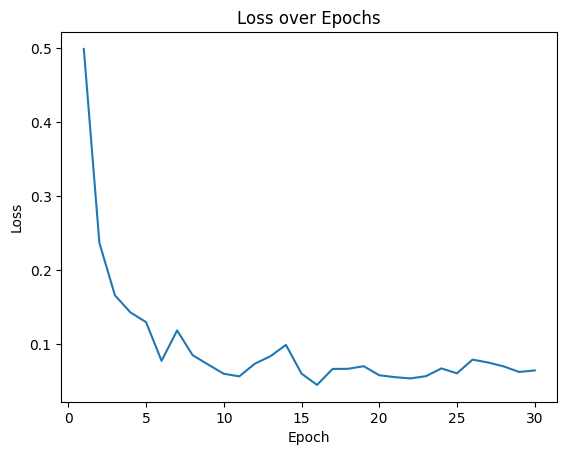

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 88.16%
Precision: 88.26%
Recall: 88.16%
F1-Score: 88.19%


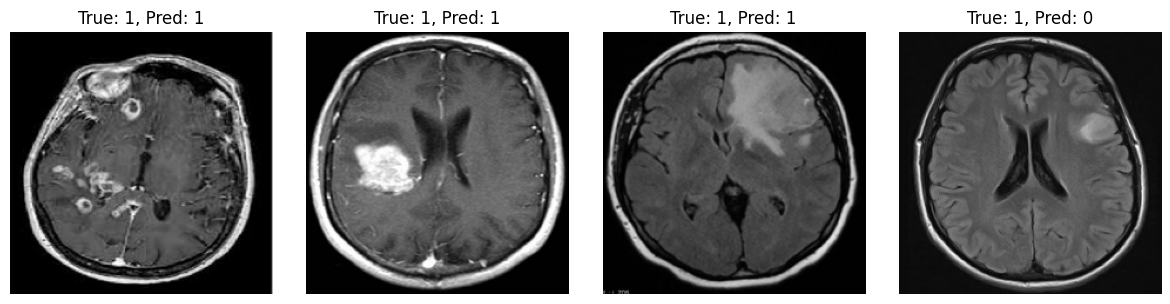

(0.881578947368421, 0.882627765064836, 0.881578947368421, 0.8819458432850853)

In [ ]:
# Train and evaluate on Brain MRI dataset
print("Training and evaluating on Brain MRI dataset...")
mlp_model = initialize_mlp()
train_mlp_classifier(feature_extractor, mlp_model, brain_mri_train_loader)
torch.save(mlp_model.state_dict(), '/content/drive/MyDrive/mlp_brain_mri.pth')
test_mlp_classifier(feature_extractor, mlp_model, brain_mri_test_loader, save_path='/content/drive/MyDrive/mlp_brain_mri.pth')


Training and evaluating on Chest X-ray dataset...
Epoch [1/30], Loss: 0.21617246704873133
Epoch [2/30], Loss: 0.11357119654882357
Epoch [3/30], Loss: 0.1059037866299412
Epoch [4/30], Loss: 0.09362210142797579
Epoch [5/30], Loss: 0.08032681669559946
Epoch [6/30], Loss: 0.057039019725988245
Epoch [7/30], Loss: 0.0534655819789855
Epoch [8/30], Loss: 0.05891964546593329
Epoch [9/30], Loss: 0.04543887448005744
Epoch [10/30], Loss: 0.04961822957566088
Epoch [11/30], Loss: 0.04664372386513678
Epoch [12/30], Loss: 0.044060777285724786
Epoch [13/30], Loss: 0.04077321360247678
Epoch [14/30], Loss: 0.03888119019116589
Epoch [15/30], Loss: 0.042434836517836604
Epoch [16/30], Loss: 0.04446977252237773
Epoch [17/30], Loss: 0.03981022880144097
Epoch [18/30], Loss: 0.046014522205169765
Epoch [19/30], Loss: 0.03961691873696593
Epoch [20/30], Loss: 0.04549914561469177
Epoch [21/30], Loss: 0.043819507142597455
Epoch [22/30], Loss: 0.03988567824429758
Epoch [23/30], Loss: 0.0390745272311422
Epoch [24/30],

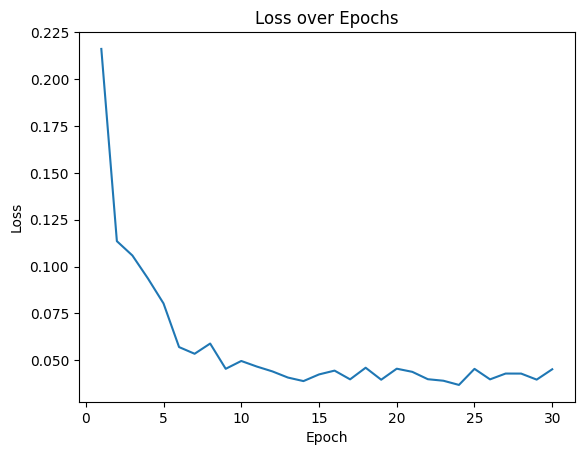

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 81.57%
Precision: 85.77%
Recall: 81.57%
F1-Score: 79.75%


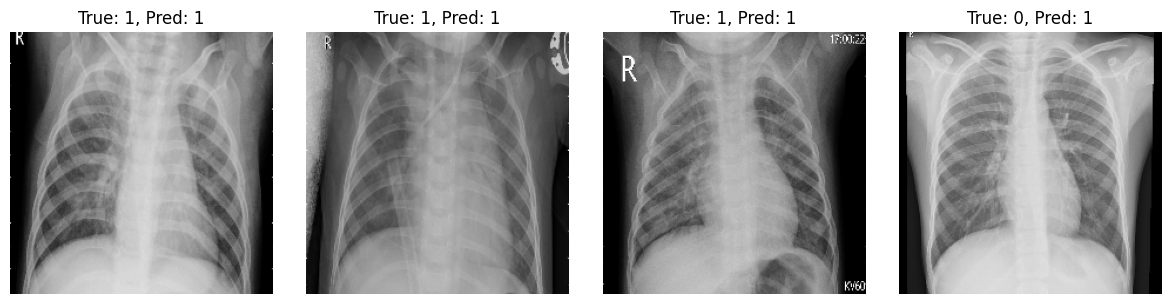

(0.8157051282051282,
 0.8576732673267327,
 0.8157051282051282,
 0.7975255986199693)

In [ ]:
# Train and evaluate on Chest X-ray dataset
print("Training and evaluating on Chest X-ray dataset...")
mlp_model = initialize_mlp()
train_mlp_classifier(feature_extractor, mlp_model, chest_xray_train_loader)
torch.save(mlp_model.state_dict(), '/content/drive/MyDrive/mlp_chest_xray.pth')
test_mlp_classifier(feature_extractor, mlp_model, chest_xray_test_loader, save_path='/content/drive/MyDrive/mlp_chest_xray.pth')

Training and evaluating on Skin Cancer dataset...
Epoch [1/30], Loss: 0.3774177214826446
Epoch [2/30], Loss: 0.29317819874688805
Epoch [3/30], Loss: 0.26889368003032293
Epoch [4/30], Loss: 0.25988301841250383
Epoch [5/30], Loss: 0.24399889700384025
Epoch [6/30], Loss: 0.21193281839410943
Epoch [7/30], Loss: 0.1919377088905817
Epoch [8/30], Loss: 0.1839441906615912
Epoch [9/30], Loss: 0.1734606858387769
Epoch [10/30], Loss: 0.16831236880227743
Epoch [11/30], Loss: 0.15905639681830464
Epoch [12/30], Loss: 0.15765562096992172
Epoch [13/30], Loss: 0.15552018394312225
Epoch [14/30], Loss: 0.15473542564425125
Epoch [15/30], Loss: 0.15126010183110294
Epoch [16/30], Loss: 0.15323090705885944
Epoch [17/30], Loss: 0.1511698707220066
Epoch [18/30], Loss: 0.15883118502167334
Epoch [19/30], Loss: 0.14551121167030678
Epoch [20/30], Loss: 0.14912617552172708
Epoch [21/30], Loss: 0.15323481188122048
Epoch [22/30], Loss: 0.14883607684309225
Epoch [23/30], Loss: 0.15983519604407162
Epoch [24/30], Loss: 

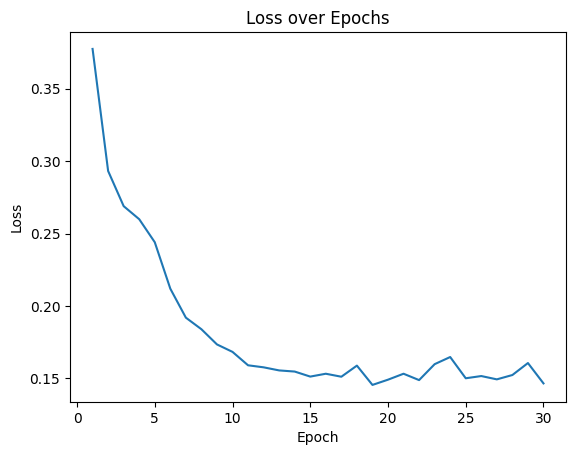

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 92.10%
Precision: 92.63%
Recall: 92.10%
F1-Score: 92.26%


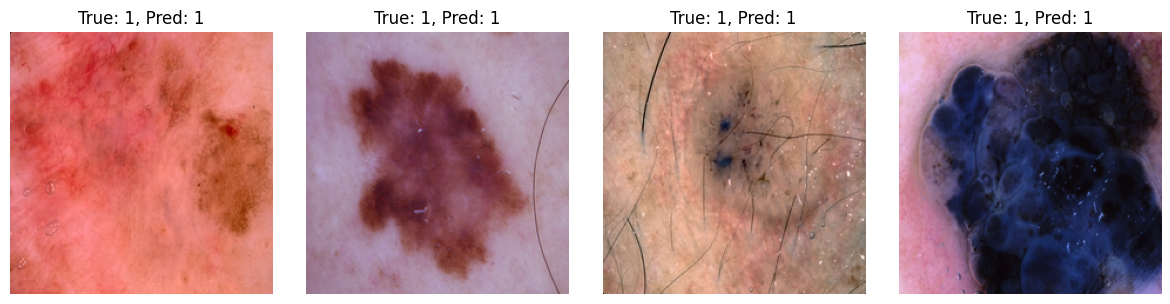

(0.9210019267822736,
 0.9263087227600926,
 0.9210019267822736,
 0.9226313466017297)

In [ ]:
# Train and evaluate on Chest Skin Cancer dataset
print("Training and evaluating on Skin Cancer dataset...")
mlp_model = initialize_mlp()
train_mlp_classifier(feature_extractor, mlp_model, skin_cancer_train_loader)
torch.save(mlp_model.state_dict(), '/content/drive/MyDrive/skin_cancer.pth')
test_mlp_classifier(feature_extractor, mlp_model, skin_cancer_test_loader, save_path='/content/drive/MyDrive/skin_cancer.pth')

Function to train the model on different percentages of the datasets: 25%, 50%, 75%, 100%, and compare the full test results.

In [ ]:
from sklearn.utils import resample

# Utility function to reset the weights of the model so that each training starts from 0.
def reset_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

def train_and_evaluate_with_different_percentages(feature_extractor, mlp_model, train_loader_full, test_loader, num_epochs=30):
    percentages = [0.25, 0.5, 0.75, 1.0]
    results = []

    for percentage in percentages:
        print(f"\nTraining with {int(percentage * 100)}% of the dataset...")

        # Subsample the training dataset
        subset_size = int(percentage * len(train_loader_full.dataset))
        indices = resample(range(len(train_loader_full.dataset)), n_samples=subset_size, random_state=42)

        # Use SubsetRandomSampler to sample the data
        subset_sampler = torch.utils.data.SubsetRandomSampler(indices)
        subset_loader = DataLoader(train_loader_full.dataset, batch_size=32, sampler=subset_sampler)

        # Reinitialize the MLP model for each percentage
        mlp_model.apply(reset_weights)

        # Train the model on the subsample
        train_mlp_classifier(feature_extractor, mlp_model, subset_loader, num_epochs)

        # Test the model on the full test set
        accuracy, precision, recall, f1 = test_mlp_classifier(feature_extractor, mlp_model, test_loader)
        results.append((percentage, accuracy, precision, recall, f1))

        print(f"Results for {int(percentage * 100)}% dataset - Accuracy: {accuracy * 100:.2f}%, F1-Score: {f1 * 100:.2f}%")

    # Plot performance metrics
    percentages = [p * 100 for p, _, _, _, _ in results]
    accuracies = [acc * 100 for _, acc, _, _, _ in results]
    f1_scores = [f1 * 100 for _, _, _, _, f1 in results]

    plt.plot(percentages, accuracies, label='Accuracy')
    plt.plot(percentages, f1_scores, label='F1-Score')
    plt.xlabel('Percentage of Dataset Used (%)')
    plt.ylabel('Performance (%)')
    plt.title('Performance vs. Dataset Size')
    plt.legend()
    plt.show()


Training and Evalutation of all three datasets with metric results, epoch plots and random examples of images predictions. All of which were done with different percentages of the datasets. Results shown for 25%, 50%, 75% and 100% of the datasets for comparison.

Evaluating on different percentages for Brain MRI dataset...

Training with 25% of the dataset...
Epoch [1/30], Loss: 0.6960456967353821
Epoch [2/30], Loss: 0.3367592841386795
Epoch [3/30], Loss: 0.26946398615837097
Epoch [4/30], Loss: 0.19933342933654785
Epoch [5/30], Loss: 0.15545104071497917
Epoch [6/30], Loss: 0.11523910239338875
Epoch [7/30], Loss: 0.12738365307450294
Epoch [8/30], Loss: 0.1307702511548996
Epoch [9/30], Loss: 0.1704377606511116
Epoch [10/30], Loss: 0.12189654260873795
Epoch [11/30], Loss: 0.10766065493226051
Epoch [12/30], Loss: 0.1546558104455471
Epoch [13/30], Loss: 0.0908002033829689
Epoch [14/30], Loss: 0.12100549787282944
Epoch [15/30], Loss: 0.11950336396694183
Epoch [16/30], Loss: 0.14301810786128044
Epoch [17/30], Loss: 0.10818437114357948
Epoch [18/30], Loss: 0.24752113223075867
Epoch [19/30], Loss: 0.10262908786535263
Epoch [20/30], Loss: 0.1254955679178238
Epoch [21/30], Loss: 0.09206034243106842
Epoch [22/30], Loss: 0.0927494615316391
Epoch [23/30], Lo

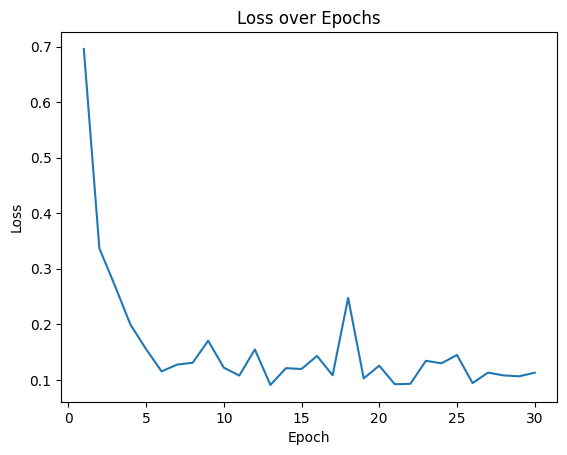

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 84.21%
Precision: 85.66%
Recall: 84.21%
F1-Score: 84.41%


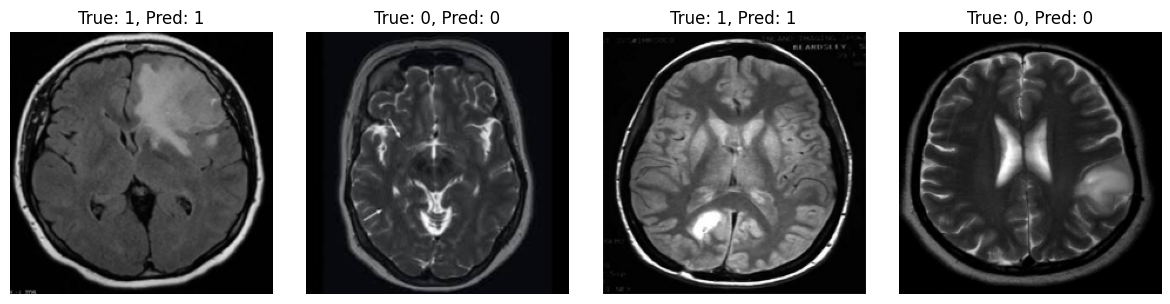

Results for 25% dataset - Accuracy: 84.21%, F1-Score: 84.41%

Training with 50% of the dataset...
Epoch [1/30], Loss: 0.5461004078388214
Epoch [2/30], Loss: 0.2563372055689494
Epoch [3/30], Loss: 0.19425603250662485
Epoch [4/30], Loss: 0.13718494772911072
Epoch [5/30], Loss: 0.10415444895625114
Epoch [6/30], Loss: 0.08185199275612831
Epoch [7/30], Loss: 0.06595474729935329
Epoch [8/30], Loss: 0.087832722812891
Epoch [9/30], Loss: 0.06949131687482198
Epoch [10/30], Loss: 0.06661684314409892
Epoch [11/30], Loss: 0.05599688986937205
Epoch [12/30], Loss: 0.05904297779003779
Epoch [13/30], Loss: 0.06434199462334315
Epoch [14/30], Loss: 0.10691774388154347
Epoch [15/30], Loss: 0.06240725641449293
Epoch [16/30], Loss: 0.055807131032148995
Epoch [17/30], Loss: 0.05153616890311241
Epoch [18/30], Loss: 0.05787552831073602
Epoch [19/30], Loss: 0.07266208032766978
Epoch [20/30], Loss: 0.053188727547725044
Epoch [21/30], Loss: 0.07071181014180183
Epoch [22/30], Loss: 0.05854490399360657
Epoch [23/3

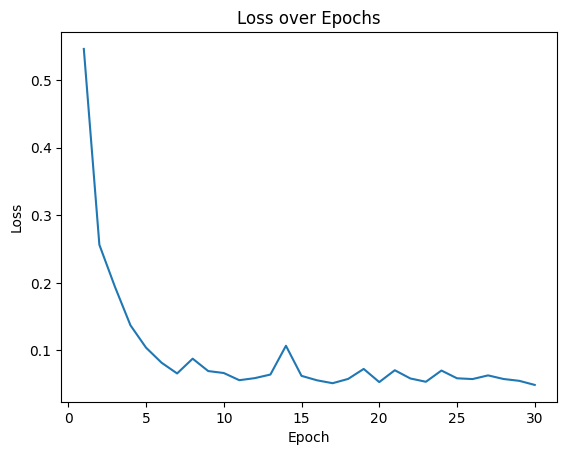

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 84.21%
Precision: 86.52%
Recall: 84.21%
F1-Score: 84.43%


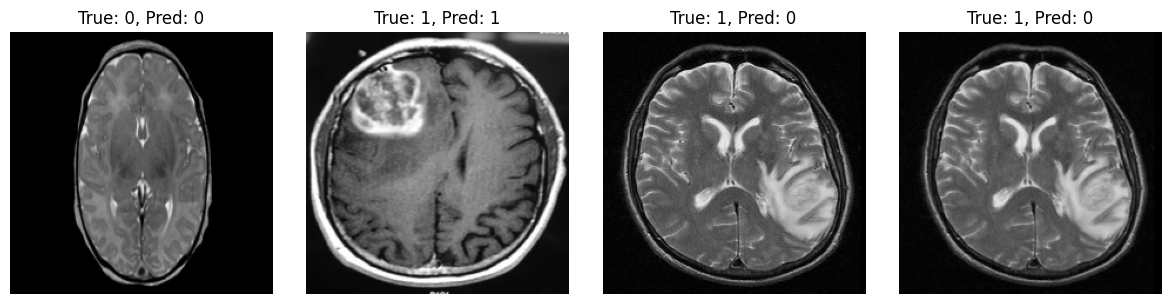

Results for 50% dataset - Accuracy: 84.21%, F1-Score: 84.43%

Training with 75% of the dataset...
Epoch [1/30], Loss: 0.644577431678772
Epoch [2/30], Loss: 0.37680108547210694
Epoch [3/30], Loss: 0.2596189260482788
Epoch [4/30], Loss: 0.16688237190246583
Epoch [5/30], Loss: 0.13605258017778396
Epoch [6/30], Loss: 0.12118832767009735
Epoch [7/30], Loss: 0.09334652684628963
Epoch [8/30], Loss: 0.11526590138673783
Epoch [9/30], Loss: 0.13908462822437287
Epoch [10/30], Loss: 0.09459542036056519
Epoch [11/30], Loss: 0.12542482167482377
Epoch [12/30], Loss: 0.34316679537296296
Epoch [13/30], Loss: 0.10085027366876602
Epoch [14/30], Loss: 0.09043281376361847
Epoch [15/30], Loss: 0.09037213325500489
Epoch [16/30], Loss: 0.08939752578735352
Epoch [17/30], Loss: 0.07529691010713577
Epoch [18/30], Loss: 0.0765974884852767
Epoch [19/30], Loss: 0.07559504322707652
Epoch [20/30], Loss: 0.10852337926626206
Epoch [21/30], Loss: 0.3561202250421047
Epoch [22/30], Loss: 0.08735115602612495
Epoch [23/30],

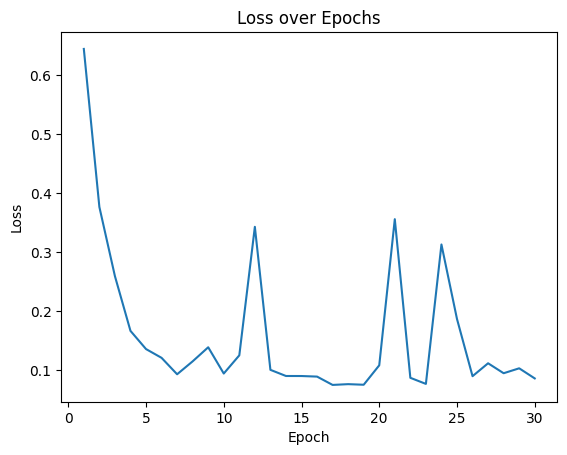

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 86.84%
Precision: 88.26%
Recall: 86.84%
F1-Score: 87.01%


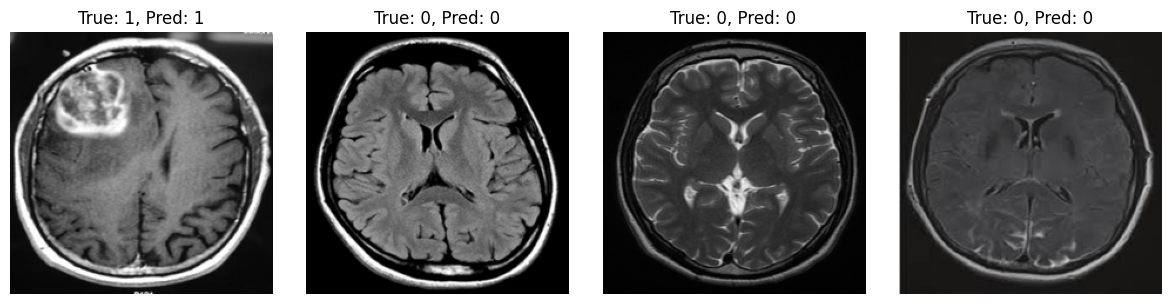

Results for 75% dataset - Accuracy: 86.84%, F1-Score: 87.01%

Training with 100% of the dataset...
Epoch [1/30], Loss: 0.5258930971225103
Epoch [2/30], Loss: 0.1689721867442131
Epoch [3/30], Loss: 0.10591070105632146
Epoch [4/30], Loss: 0.07923410646617413
Epoch [5/30], Loss: 0.07208795472979546
Epoch [6/30], Loss: 0.0516154874737064
Epoch [7/30], Loss: 0.04347108335544666
Epoch [8/30], Loss: 0.05029715349276861
Epoch [9/30], Loss: 0.04018545833726724
Epoch [10/30], Loss: 0.032077223528176546
Epoch [11/30], Loss: 0.031077199925978977
Epoch [12/30], Loss: 0.026208436737457912
Epoch [13/30], Loss: 0.03078784855703513
Epoch [14/30], Loss: 0.03357190111031135
Epoch [15/30], Loss: 0.029870633967220783
Epoch [16/30], Loss: 0.04859210178256035
Epoch [17/30], Loss: 0.04469004428635041
Epoch [18/30], Loss: 0.04275463676700989
Epoch [19/30], Loss: 0.029088125564157963
Epoch [20/30], Loss: 0.037347884848713875
Epoch [21/30], Loss: 0.04068506322801113
Epoch [22/30], Loss: 0.06803400410960118
Epoch

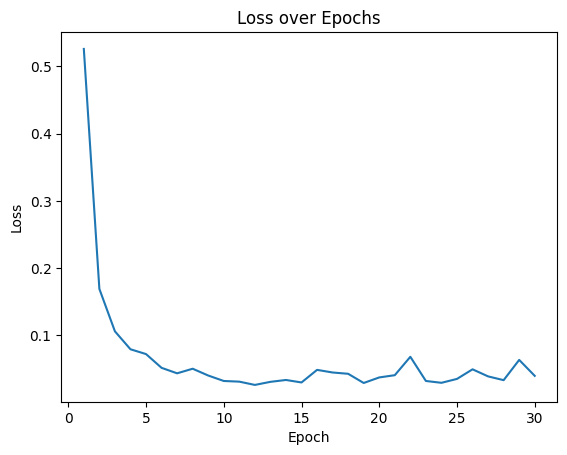

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 82.89%
Precision: 84.76%
Recall: 82.89%
F1-Score: 83.13%


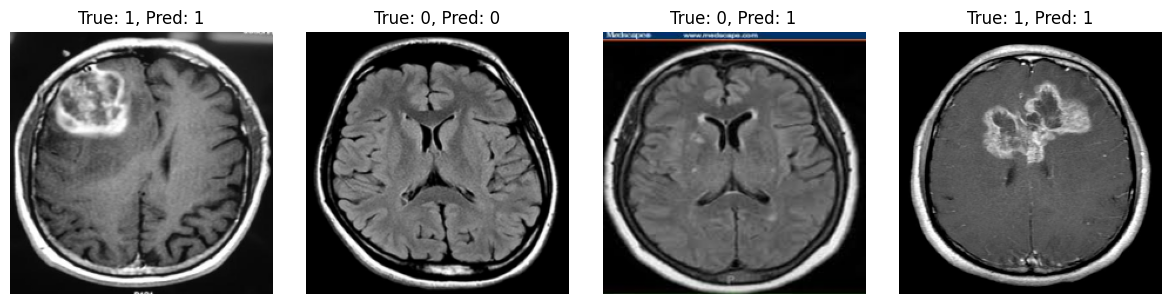

Results for 100% dataset - Accuracy: 82.89%, F1-Score: 83.13%


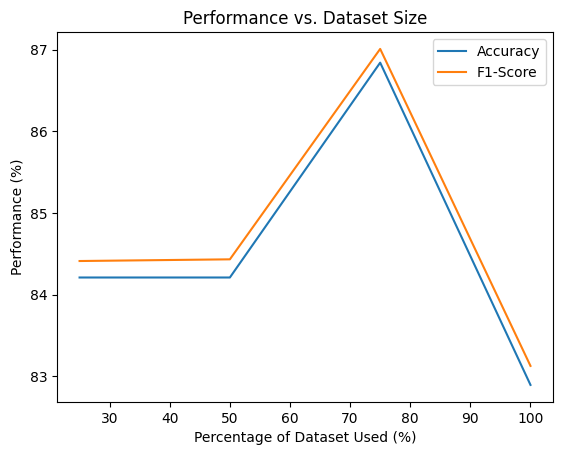

In [ ]:
# For Brain MRI dataset
print("Evaluating on different percentages for Brain MRI dataset...")
mlp_model = initialize_mlp()
train_and_evaluate_with_different_percentages(feature_extractor, mlp_model, brain_mri_train_loader, brain_mri_test_loader)



Evaluating on different percentages for Chest X-ray dataset...

Training with 25% of the dataset...
Epoch [1/30], Loss: 0.31730813151452597
Epoch [2/30], Loss: 0.15166855894210862
Epoch [3/30], Loss: 0.11146656346575516
Epoch [4/30], Loss: 0.11966825158494275
Epoch [5/30], Loss: 0.07594266997241392
Epoch [6/30], Loss: 0.07843221233385365
Epoch [7/30], Loss: 0.051254914119476226
Epoch [8/30], Loss: 0.046529715233368844
Epoch [9/30], Loss: 0.03983893465795895
Epoch [10/30], Loss: 0.051444848863089955
Epoch [11/30], Loss: 0.040490681771188974
Epoch [12/30], Loss: 0.054248143680302834
Epoch [13/30], Loss: 0.03781901428294254
Epoch [14/30], Loss: 0.03838829563294605
Epoch [15/30], Loss: 0.03237413203843483
Epoch [16/30], Loss: 0.03165936523412422
Epoch [17/30], Loss: 0.04034798813802076
Epoch [18/30], Loss: 0.03814582348369607
Epoch [19/30], Loss: 0.03828008363886577
Epoch [20/30], Loss: 0.0317241780846039
Epoch [21/30], Loss: 0.03822616318513344
Epoch [22/30], Loss: 0.0609507332101646
Epoc

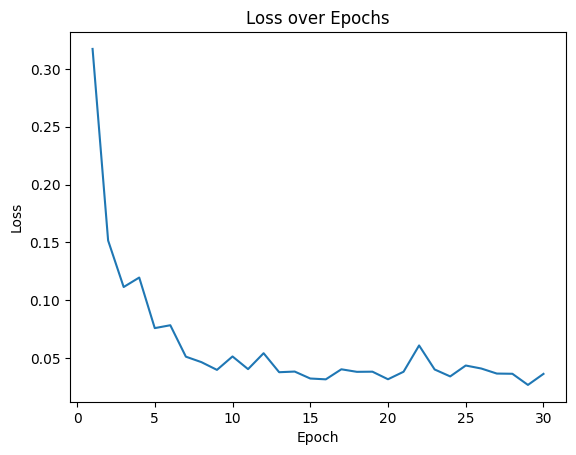

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 85.10%
Precision: 87.78%
Recall: 85.10%
F1-Score: 84.08%


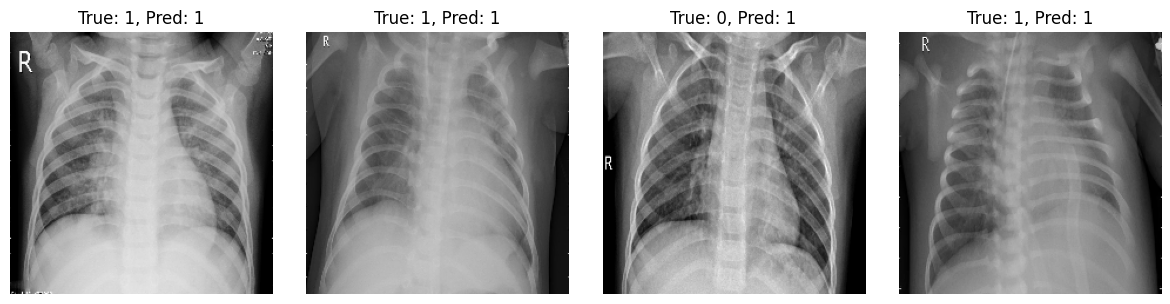

Results for 25% dataset - Accuracy: 85.10%, F1-Score: 84.08%

Training with 50% of the dataset...
Epoch [1/30], Loss: 0.23712001000417443
Epoch [2/30], Loss: 0.1337231485763701
Epoch [3/30], Loss: 0.10630304604859614
Epoch [4/30], Loss: 0.09975195599992465
Epoch [5/30], Loss: 0.07518168906226935
Epoch [6/30], Loss: 0.06655699509286844
Epoch [7/30], Loss: 0.04891662633546242
Epoch [8/30], Loss: 0.044214643095052096
Epoch [9/30], Loss: 0.04942698671664225
Epoch [10/30], Loss: 0.036064159482853804
Epoch [11/30], Loss: 0.04240835889060868
Epoch [12/30], Loss: 0.032850076643204905
Epoch [13/30], Loss: 0.03805860319095323
Epoch [14/30], Loss: 0.03871275225040934
Epoch [15/30], Loss: 0.04560553500849027
Epoch [16/30], Loss: 0.03981460621807634
Epoch [17/30], Loss: 0.04452324833823141
Epoch [18/30], Loss: 0.037251119286094495
Epoch [19/30], Loss: 0.04109067101849288
Epoch [20/30], Loss: 0.04449235591696712
Epoch [21/30], Loss: 0.04341584708677923
Epoch [22/30], Loss: 0.038306750678003015
Epoch

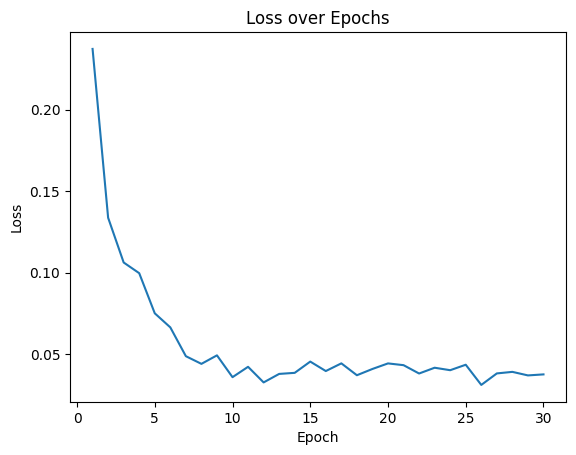

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 82.37%
Precision: 85.81%
Recall: 82.37%
F1-Score: 80.85%


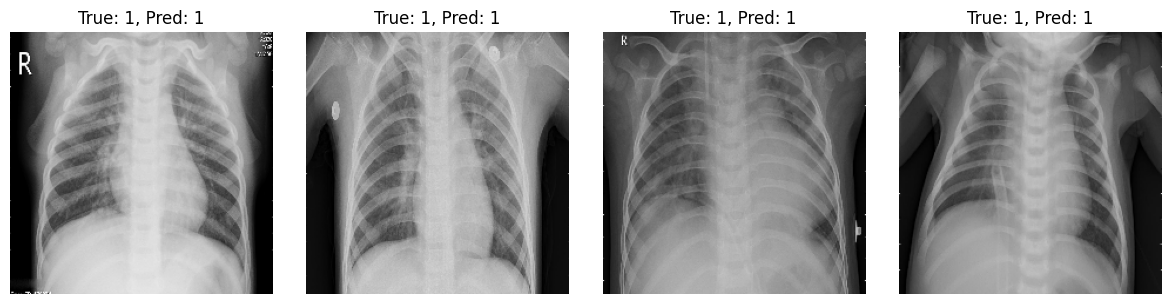

Results for 50% dataset - Accuracy: 82.37%, F1-Score: 80.85%

Training with 75% of the dataset...
Epoch [1/30], Loss: 0.2076395266969514
Epoch [2/30], Loss: 0.10526656801623058
Epoch [3/30], Loss: 0.08715144300273037
Epoch [4/30], Loss: 0.08082978286954566
Epoch [5/30], Loss: 0.06296362760817496
Epoch [6/30], Loss: 0.045129820742318784
Epoch [7/30], Loss: 0.03810516898936736
Epoch [8/30], Loss: 0.03691991261486721
Epoch [9/30], Loss: 0.03665676007304734
Epoch [10/30], Loss: 0.0403077629038958
Epoch [11/30], Loss: 0.029332524277194124
Epoch [12/30], Loss: 0.02227950700164992
Epoch [13/30], Loss: 0.03075562337057559
Epoch [14/30], Loss: 0.02448069426321947
Epoch [15/30], Loss: 0.0329310836618751
Epoch [16/30], Loss: 0.036919847783837015
Epoch [17/30], Loss: 0.039247019117985796
Epoch [18/30], Loss: 0.04174010419169426
Epoch [19/30], Loss: 0.024642605655372324
Epoch [20/30], Loss: 0.026503153249424528
Epoch [21/30], Loss: 0.03119933820041881
Epoch [22/30], Loss: 0.03313277161687734
Epoch 

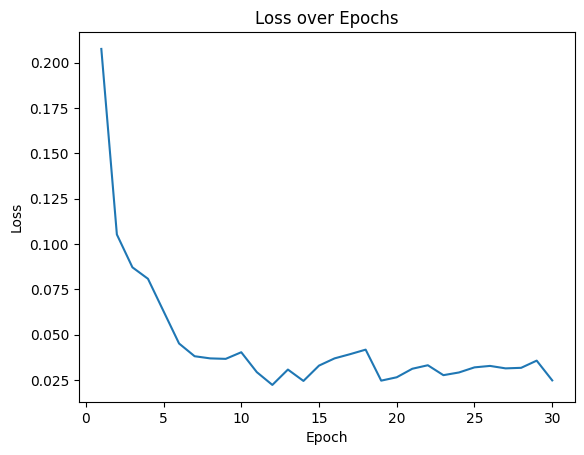

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 82.37%
Precision: 86.25%
Recall: 82.37%
F1-Score: 80.75%


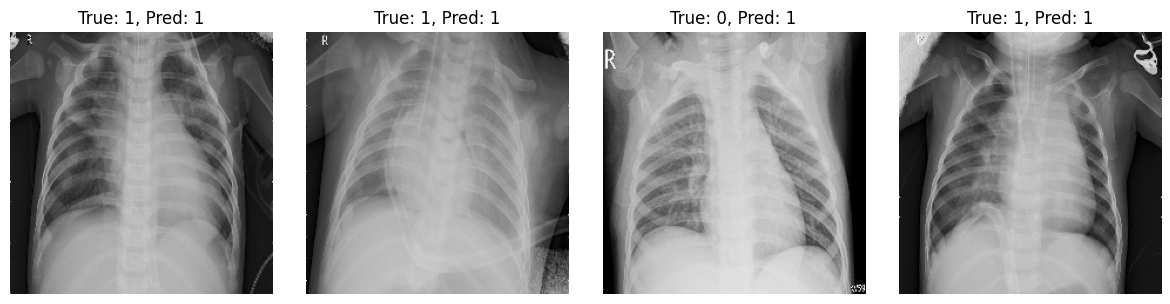

Results for 75% dataset - Accuracy: 82.37%, F1-Score: 80.75%

Training with 100% of the dataset...
Epoch [1/30], Loss: 0.17526312378103748
Epoch [2/30], Loss: 0.09375232787220025
Epoch [3/30], Loss: 0.07671642950250328
Epoch [4/30], Loss: 0.06098495779610439
Epoch [5/30], Loss: 0.06027271347177541
Epoch [6/30], Loss: 0.03465813945156116
Epoch [7/30], Loss: 0.031110866578078707
Epoch [8/30], Loss: 0.034714056724579605
Epoch [9/30], Loss: 0.023304955830991816
Epoch [10/30], Loss: 0.022846081466242625
Epoch [11/30], Loss: 0.033330967101308465
Epoch [12/30], Loss: 0.0252295740407983
Epoch [13/30], Loss: 0.025306719749526013
Epoch [14/30], Loss: 0.029033232465289258
Epoch [15/30], Loss: 0.0240926890294039
Epoch [16/30], Loss: 0.020379450167900673
Epoch [17/30], Loss: 0.019042601040421638
Epoch [18/30], Loss: 0.024625707417726517
Epoch [19/30], Loss: 0.023606885588825025
Epoch [20/30], Loss: 0.029156861668224076
Epoch [21/30], Loss: 0.023323859767331256
Epoch [22/30], Loss: 0.020086482917872

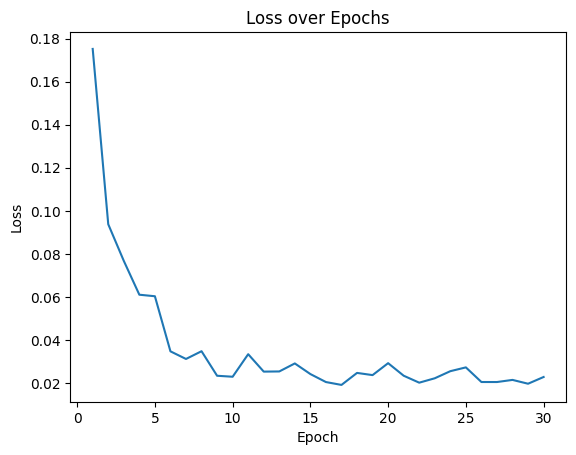

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 81.73%
Precision: 85.40%
Recall: 81.73%
F1-Score: 80.05%


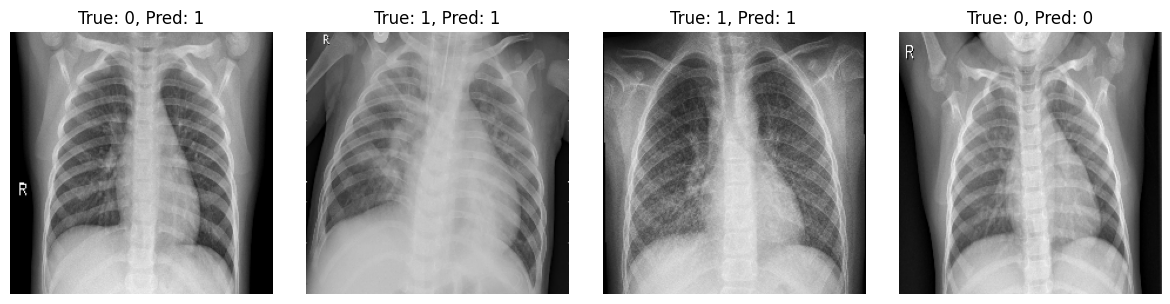

Results for 100% dataset - Accuracy: 81.73%, F1-Score: 80.05%


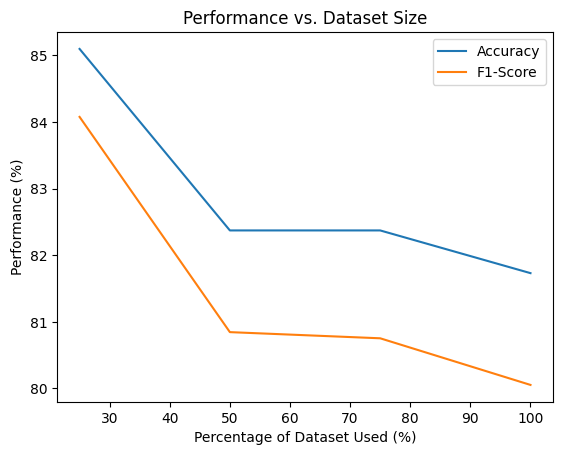

In [ ]:

# For Chest X-ray dataset
print("Evaluating on different percentages for Chest X-ray dataset...")
mlp_model = initialize_mlp()
train_and_evaluate_with_different_percentages(feature_extractor, mlp_model, chest_xray_train_loader, chest_xray_test_loader)

Evaluating on different percentages for Skin Cancer dataset...

Training with 25% of the dataset...
Epoch [1/30], Loss: 0.4961684601647513
Epoch [2/30], Loss: 0.32481419046719867
Epoch [3/30], Loss: 0.2624585365965253
Epoch [4/30], Loss: 0.22488499113491603
Epoch [5/30], Loss: 0.21958832974944795
Epoch [6/30], Loss: 0.14509885598506247
Epoch [7/30], Loss: 0.142128421969357
Epoch [8/30], Loss: 0.10892362289485477
Epoch [9/30], Loss: 0.09521929174661636
Epoch [10/30], Loss: 0.11774713687953495
Epoch [11/30], Loss: 0.0893705387910207
Epoch [12/30], Loss: 0.08557598292827606
Epoch [13/30], Loss: 0.08856347451607387
Epoch [14/30], Loss: 0.1029526639197554
Epoch [15/30], Loss: 0.0913679583796433
Epoch [16/30], Loss: 0.10442405335959934
Epoch [17/30], Loss: 0.08749255342852502
Epoch [18/30], Loss: 0.10220554861284438
Epoch [19/30], Loss: 0.10060433990189008
Epoch [20/30], Loss: 0.12081062669555347
Epoch [21/30], Loss: 0.09516394280252002
Epoch [22/30], Loss: 0.07867202517532167
Epoch [23/30],

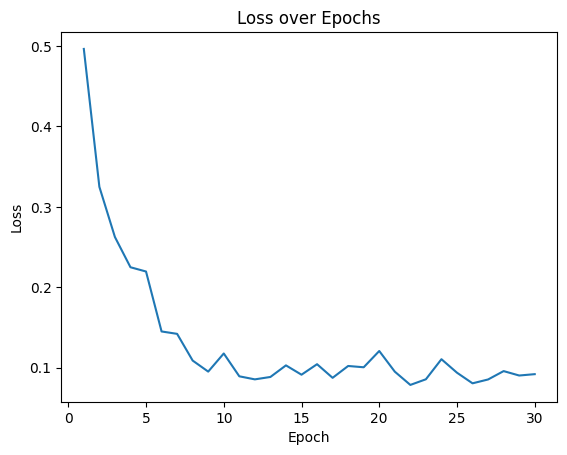

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 86.19%
Precision: 88.47%
Recall: 86.19%
F1-Score: 86.80%


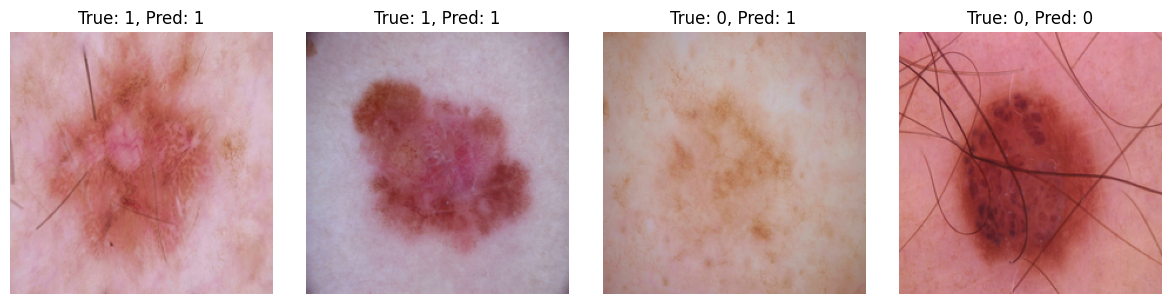

Results for 25% dataset - Accuracy: 86.19%, F1-Score: 86.80%

Training with 50% of the dataset...
Epoch [1/30], Loss: 0.4610139174120767
Epoch [2/30], Loss: 0.3022169584319705
Epoch [3/30], Loss: 0.23423141489426294
Epoch [4/30], Loss: 0.22651270120626404
Epoch [5/30], Loss: 0.17635466672834896
Epoch [6/30], Loss: 0.13627199819754987
Epoch [7/30], Loss: 0.1046102148968549
Epoch [8/30], Loss: 0.10840624074141185
Epoch [9/30], Loss: 0.0986517354668606
Epoch [10/30], Loss: 0.08627709892711469
Epoch [11/30], Loss: 0.09058528845863682
Epoch [12/30], Loss: 0.09536382343087878
Epoch [13/30], Loss: 0.07686236487435442
Epoch [14/30], Loss: 0.07357589922667969
Epoch [15/30], Loss: 0.07657347584054583
Epoch [16/30], Loss: 0.0839581298863604
Epoch [17/30], Loss: 0.07893908294361263
Epoch [18/30], Loss: 0.11371255949849174
Epoch [19/30], Loss: 0.08538812110644012
Epoch [20/30], Loss: 0.07389362837143597
Epoch [21/30], Loss: 0.07981070374981278
Epoch [22/30], Loss: 0.09053746495573294
Epoch [23/30],

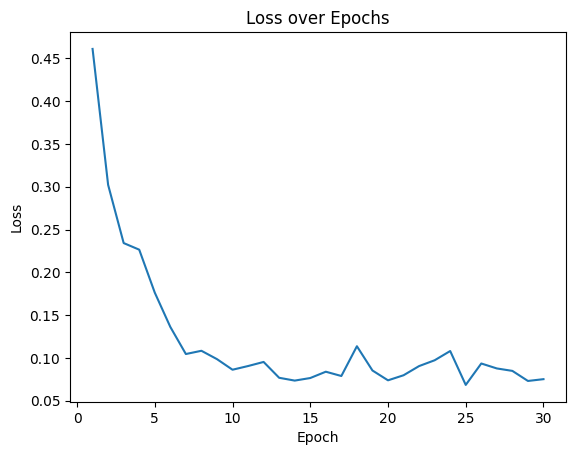

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 89.60%
Precision: 91.07%
Recall: 89.60%
F1-Score: 89.98%


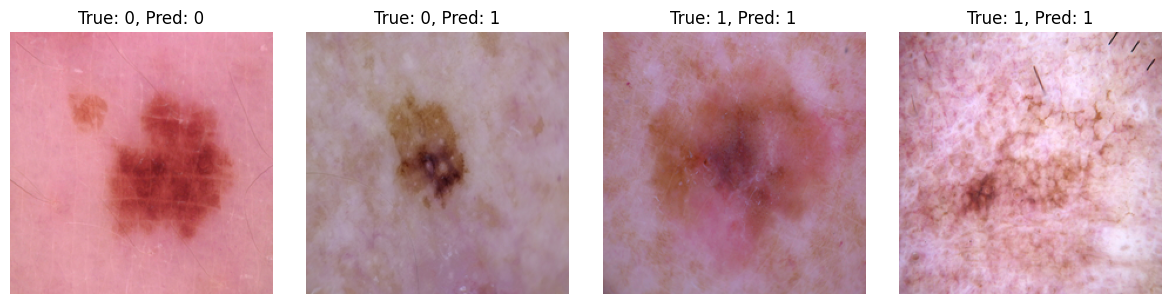

Results for 50% dataset - Accuracy: 89.60%, F1-Score: 89.98%

Training with 75% of the dataset...
Epoch [1/30], Loss: 0.38343374527269797
Epoch [2/30], Loss: 0.2540433385199116
Epoch [3/30], Loss: 0.23135250109818675
Epoch [4/30], Loss: 0.2146700820134532
Epoch [5/30], Loss: 0.19719346288231113
Epoch [6/30], Loss: 0.14615656219182477
Epoch [7/30], Loss: 0.13002527961807867
Epoch [8/30], Loss: 0.11992622773733831
Epoch [9/30], Loss: 0.10420249624838752
Epoch [10/30], Loss: 0.11841653777106155
Epoch [11/30], Loss: 0.0963026553152069
Epoch [12/30], Loss: 0.09367503276875903
Epoch [13/30], Loss: 0.09045034878316426
Epoch [14/30], Loss: 0.09446463842065103
Epoch [15/30], Loss: 0.08876119761337195
Epoch [16/30], Loss: 0.0972247764828705
Epoch [17/30], Loss: 0.09562621232602865
Epoch [18/30], Loss: 0.08894481557992197
Epoch [19/30], Loss: 0.08915135174268676
Epoch [20/30], Loss: 0.09003894779110147
Epoch [21/30], Loss: 0.09475638612263626
Epoch [22/30], Loss: 0.09665927471172425
Epoch [23/30]

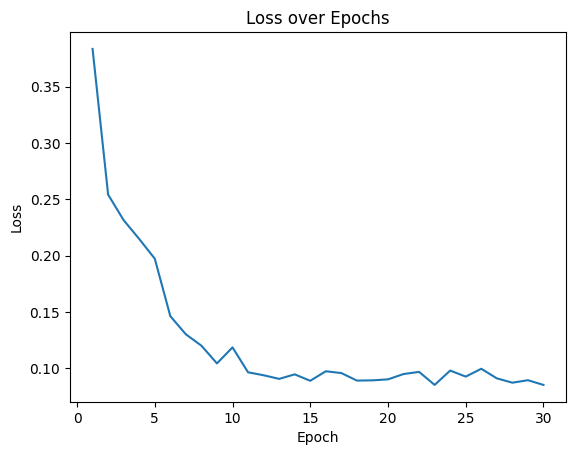

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 90.04%
Precision: 91.15%
Recall: 90.04%
F1-Score: 90.35%


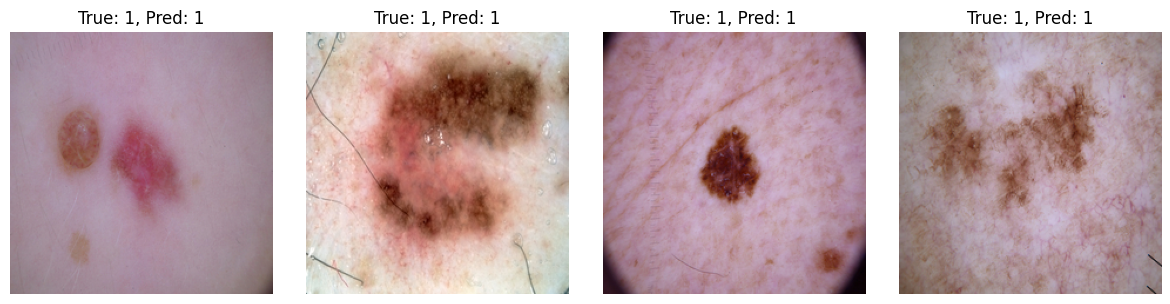

Results for 75% dataset - Accuracy: 90.04%, F1-Score: 90.35%

Training with 100% of the dataset...
Epoch [1/30], Loss: 0.36859023463295165
Epoch [2/30], Loss: 0.2648976498160018
Epoch [3/30], Loss: 0.23153481228523945
Epoch [4/30], Loss: 0.20000602417142996
Epoch [5/30], Loss: 0.20923223938927593
Epoch [6/30], Loss: 0.13898543614041375
Epoch [7/30], Loss: 0.12800930310265127
Epoch [8/30], Loss: 0.12176613045115788
Epoch [9/30], Loss: 0.10984849653779025
Epoch [10/30], Loss: 0.10688999488231647
Epoch [11/30], Loss: 0.09764067404510746
Epoch [12/30], Loss: 0.09141225906380687
Epoch [13/30], Loss: 0.09437660738287201
Epoch [14/30], Loss: 0.09542467079338539
Epoch [15/30], Loss: 0.08513485146574228
Epoch [16/30], Loss: 0.08961909001760454
Epoch [17/30], Loss: 0.08974429700209434
Epoch [18/30], Loss: 0.0944196506885879
Epoch [19/30], Loss: 0.10489591397345066
Epoch [20/30], Loss: 0.08921189406460309
Epoch [21/30], Loss: 0.08854280120457511
Epoch [22/30], Loss: 0.09374494632952902
Epoch [23/

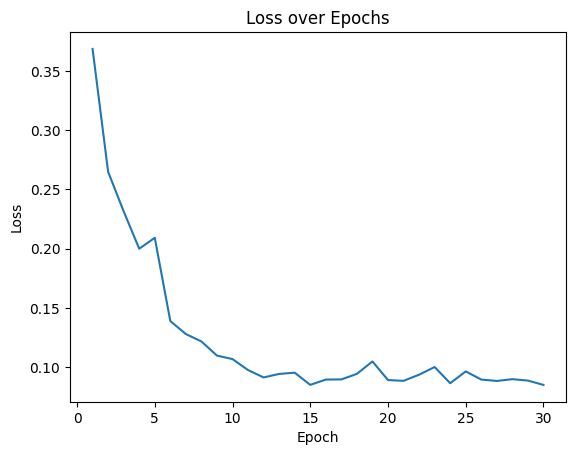

<ipython-input-31-76adf0a58e53>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(save_path))


Accuracy: 92.16%
Precision: 92.77%
Recall: 92.16%
F1-Score: 92.34%


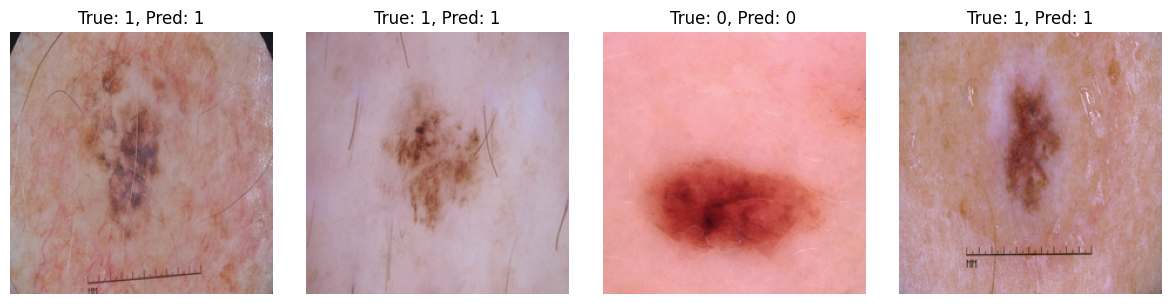

Results for 100% dataset - Accuracy: 92.16%, F1-Score: 92.34%


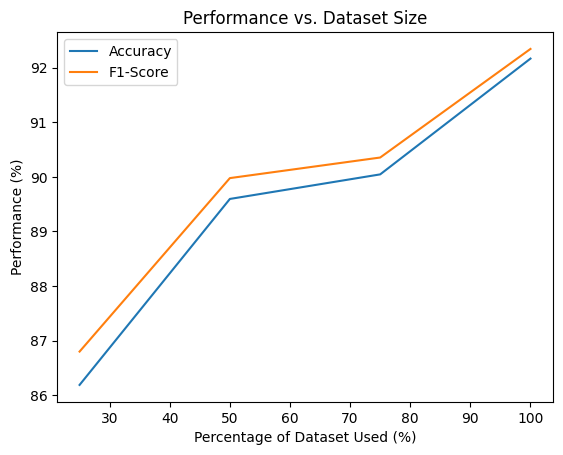

In [ ]:
# For Skin Cancer dataset
print("Evaluating on different percentages for Skin Cancer dataset...")
mlp_model = initialize_mlp()
train_and_evaluate_with_different_percentages(feature_extractor, mlp_model, skin_cancer_train_loader, skin_cancer_test_loader)